In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import itertools

import time

# used to supress display of warnings
import warnings

# ols library
import statsmodels.api as sm
import statsmodels.formula.api as smf

import missingno as mno
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

# import zscore for scaling the data
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# pre-processing methods
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.compose import TransformedTargetRegressor

# the regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# cross-validation methods
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics

from sklearn.pipeline import Pipeline

# feature-selection methods
from sklearn.feature_selection import SelectFromModel

# bootstrap sampling
from sklearn.utils import resample

In [3]:
# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

**Import dataset**

In [4]:
water_df = pd.read_csv("water_potability.csv")

**Checking dataset information**

In [5]:
water_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.8904555,20791.3189807,7.3002119,368.5164413,564.3086542,10.3797831,86.9909705,2.9631354,0
1,3.7160801,129.4229205,18630.0578580,6.6352459,NaN,592.8853591,15.1800131,56.3290763,4.5006563,0
2,8.0991242,224.2362594,19909.5417323,9.2758836,NaN,418.6062131,16.8686369,66.4200925,3.0559337,0
3,8.3167659,214.3733941,22018.4174408,8.0593324,356.8861356,363.2665162,18.4365245,100.3416744,4.6287705,0
4,9.0922235,181.1015092,17978.9863389,6.5466000,310.1357375,398.4108134,11.5582794,31.9979927,4.0750754,0


In [6]:
water_df.shape

(3276, 10)

In [7]:
water_df.dtypes

,0
ph,float64
Hardness,float64
Solids,float64
Chloramines,float64
Sulfate,float64
Conductivity,float64
Organic_carbon,float64
Trihalomethanes,float64
Turbidity,float64
Potability,int64


In [8]:
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [9]:
COLS = [c for c in water_df.columns]
print(COLS)

['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


# **Data cleaning**

**Checking outliers**

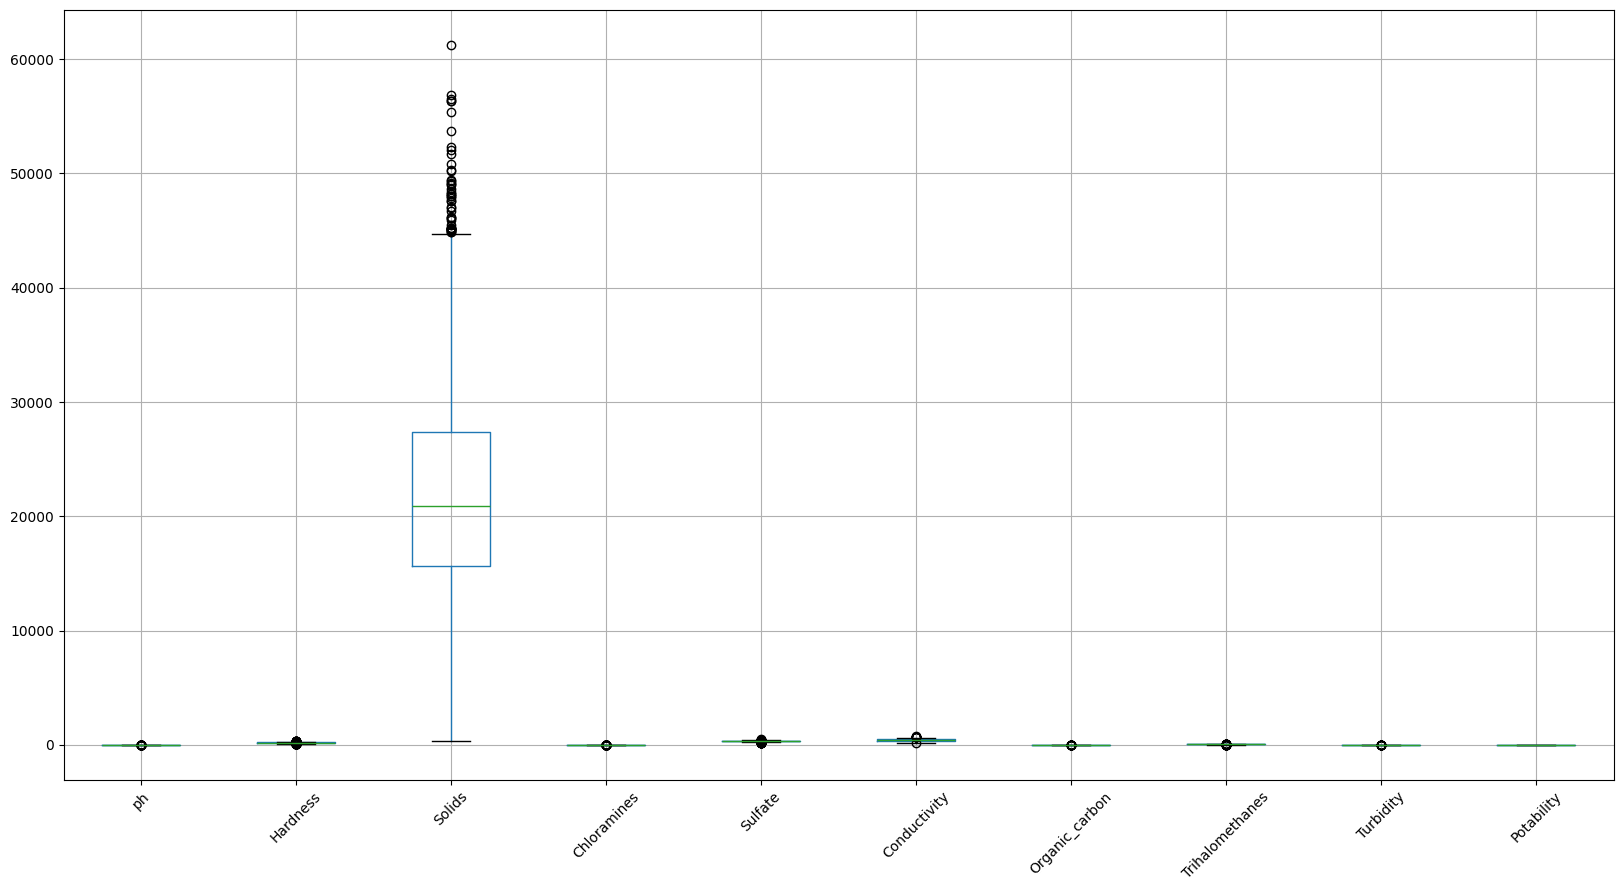

In [10]:
water_df.boxplot(column=COLS, rot=45, figsize=(20, 10))
plt.show()

In [11]:
water_df_outliers = pd.DataFrame(water_df.loc[:,])
Q1 = water_df_outliers.quantile(0.25)
Q3 = water_df_outliers.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

ph                    1.9689742
Hardness             39.8169183
Solids            11666.0718305
Chloramines           1.9874663
Sulfate              52.2506726
Conductivity        116.0578904
Organic_carbon        4.4918502
Trihalomethanes      21.4929373
Turbidity             1.0606089
Potability            1.0000000
dtype: float64


In [12]:
# Filter out the outliers by using IQR method, only keep the valid data
for i, j in zip(np.where(water_df_outliers > Q3 + 1.5 * IQR)[0], np.where(water_df_outliers > Q3 + 1.5 * IQR)[1]):
  whisker  = Q3 + 1.5 * IQR
  water_df_outliers.iloc[i,j] = whisker[j]

# Replace every outlier on the lower side by the lower whisker - for 'water' column
for i, j in zip(np.where(water_df_outliers < Q1 - 1.5 * IQR)[0], np.where(water_df_outliers < Q1 - 1.5 * IQR)[1]):
  whisker  = Q1 - 1.5 * IQR
  water_df_outliers.iloc[i,j] = whisker[j]

water_df_outliers.shape

(3276, 10)

In [13]:
# Remove outliers columns
water_df.drop(columns=water_df.loc[:,], inplace=True)

In [14]:
# Concat the cleaned data with the outliers data
water_df = pd.concat([water_df, water_df_outliers], axis=1)
water_df.shape

(3276, 10)

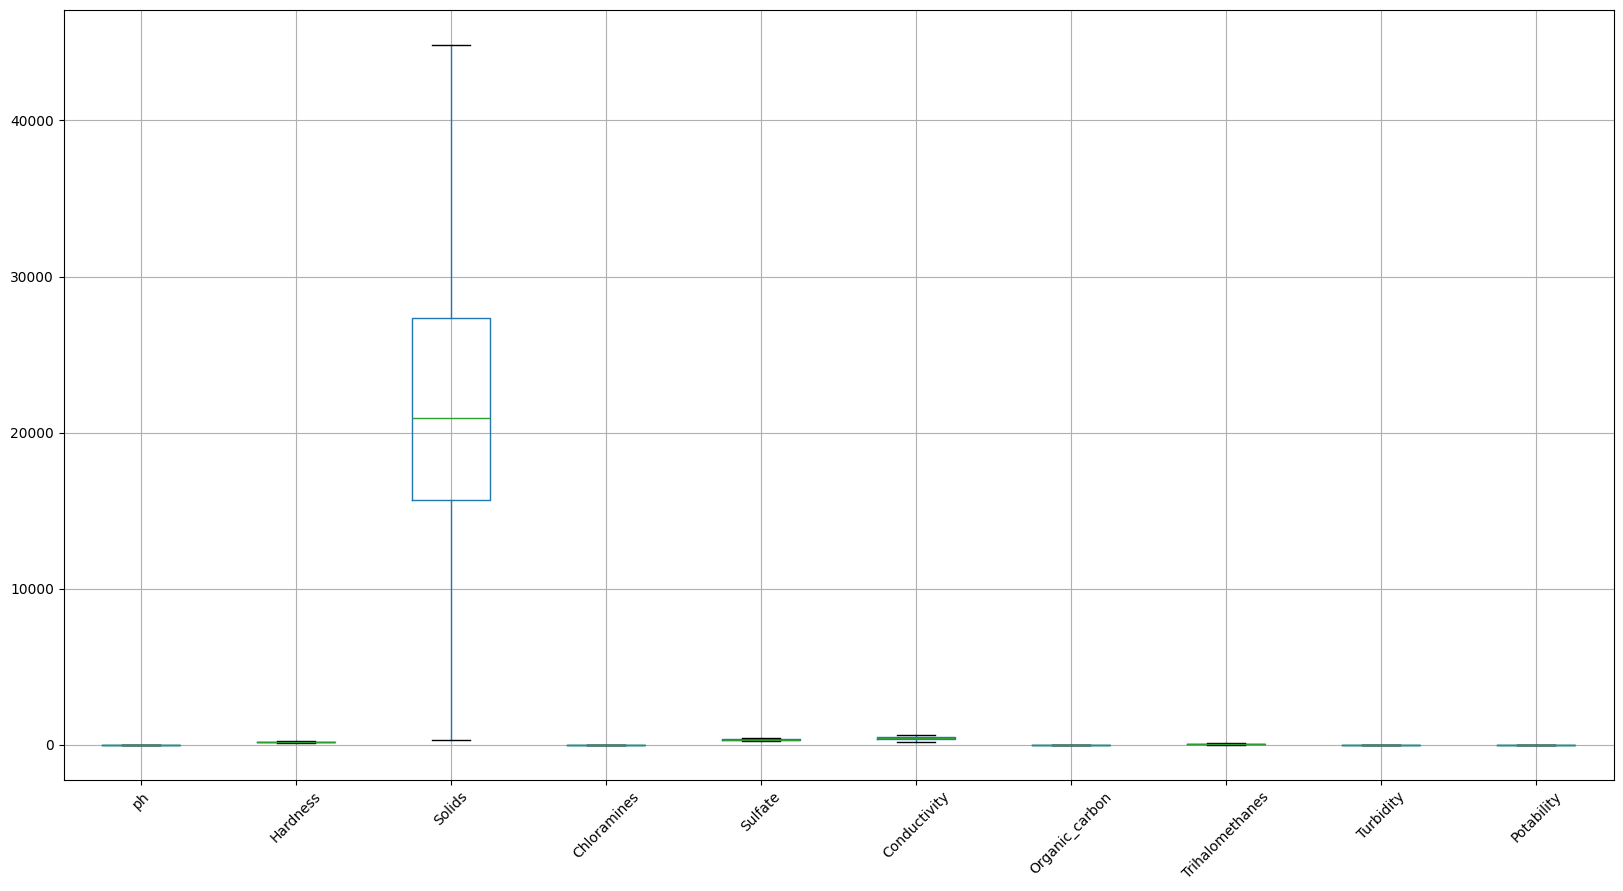

In [15]:
# Revalidate the outliers again
water_df.boxplot(column=COLS, rot=45, figsize=(20, 10))
plt.show()

**Checking missing values**

In [16]:
water_df.isnull().sum()

,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


In [17]:
#fill missing value with dataframe mean
water_df.fillna(water_df.mean(numeric_only=True), inplace=True)
water_df.isnull().sum()

,0
ph,0
Hardness,0
Solids,0
Chloramines,0
Sulfate,0
Conductivity,0
Organic_carbon,0
Trihalomethanes,0
Turbidity,0
Potability,0


In [18]:
# Check the presence of missing values
water_df_missval = water_df.copy()   # Make a copy of the dataframe
isduplicates = False

for x in water_df_missval.columns:
    water_df_missval[x] = water_df_missval[x].astype(str).str.replace(".", "")
    result = water_df_missval[x].astype(str).str.isalnum() # Check whether all characters are alphanumeric
    if False in result.unique():
        isduplicates = True
        print('For column "{}" unique values are {}'.format(x, water_df_missval[x].unique()))
        print('\n')

if not isduplicates:
    print('No duplicates in this dataset')

No duplicates in this dataset


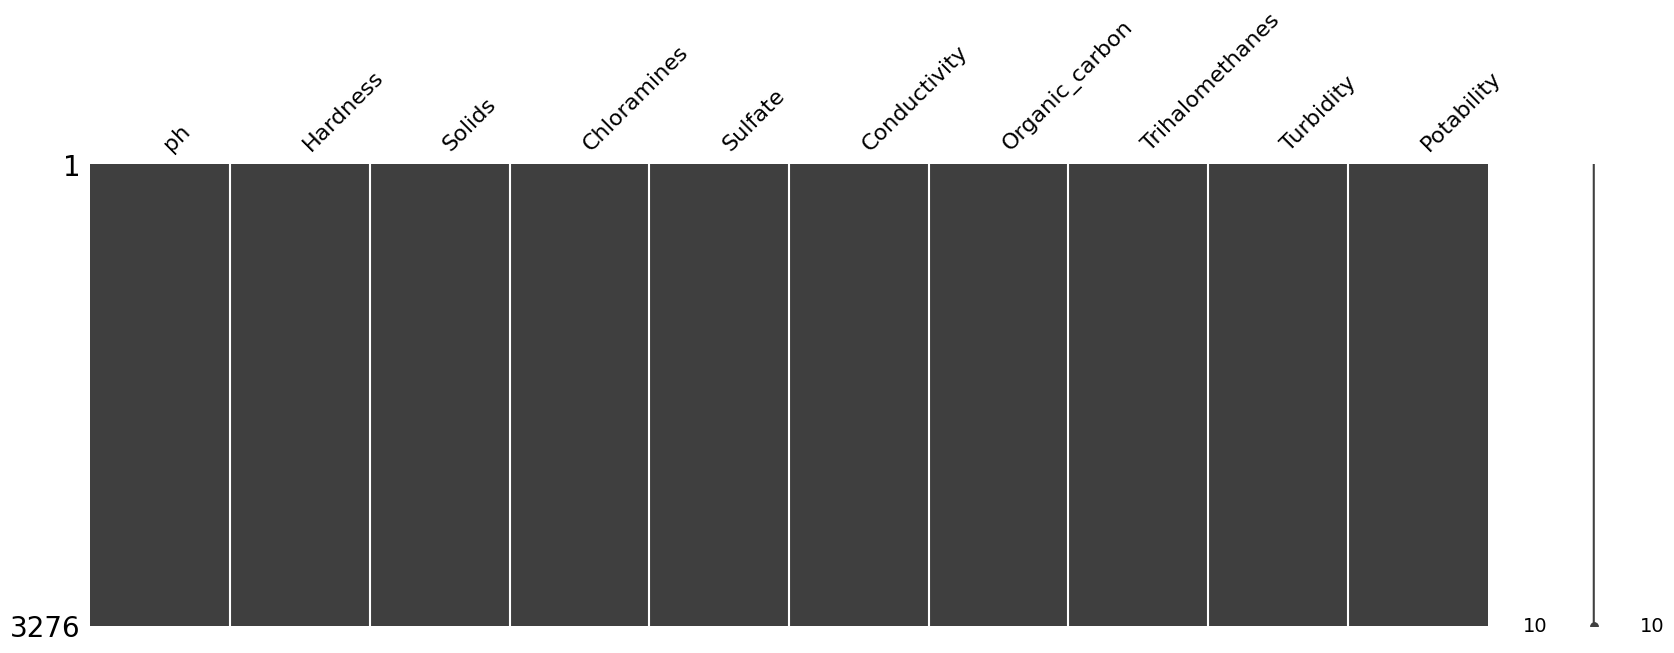

In [19]:
mno.matrix(water_df, figsize=(20, 6))
plt.show()

In [20]:
water_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,3276.0000000,7.0817377,1.4287545,3.1396306,6.2776726,7.0817377,7.8700498,11.0155274
Hardness,3276.0000000,196.3924229,32.0171893,117.1251604,176.8505379,196.9676269,216.6674562,276.3928337
Solids,3276.0000000,21957.1122000,8592.8203969,320.9426113,15666.6902970,20927.8336065,27332.7621274,44831.8698731
Chloramines,3276.0000000,7.1217940,1.5441262,3.1462213,6.1274208,7.1302990,8.1148870,11.0960864
Sulfate,3276.0000000,333.8678617,35.2991302,229.3234890,317.0946377,333.8678617,350.3857563,438.3261792
Conductivity,3276.0000000,426.1299736,80.5641438,191.6475786,365.7344141,421.8849683,481.7923045,655.8791400
Organic_carbon,3276.0000000,14.2834616,3.2883667,5.3280260,12.0658013,14.2183379,16.5576515,23.2954269
Trihalomethanes,3276.0000000,66.4152186,15.5900164,23.6051297,56.6476557,66.4152186,76.6666093,109.5768788
Turbidity,3276.0000000,3.9666121,0.7764086,1.8487975,3.4397109,3.9550276,4.5003198,6.0912332
Potability,3276.0000000,0.3901099,0.4878492,0.0000000,0.0000000,0.0000000,1.0000000,1.0000000


**Checking duplications**

In [21]:
water_df.duplicated().sum()

np.int64(0)

In [22]:
# View the duplicate records
duplicates = water_df.duplicated()

water_df[duplicates]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability


**Summary of Data Cleaning Process**

The data cleaning process involved the following steps:

1.  **Checking Outliers:** Outliers were identified and replaced using the Interquartile Range (IQR) method. Values exceeding the upper whisker (`Q3 + 1.5 * IQR`) were replaced with the upper whisker value, and values below the lower whisker (`Q1 - 1.5 * IQR`) were replaced with the lower whisker value.
2.  **Checking Missing Values:** Missing values were identified using `isnull().sum()`. The missing values in the 'ph', 'Sulfate', and 'Trihalomethanes' columns were then filled with the mean of their respective columns.
3.  **Checking Duplicates:** Duplicates were checked using the `duplicated().sum()` method. It was confirmed that there are no duplicate rows in the dataset.

In [23]:
water_df.to_csv("cleaned_data_water_potability.csv", index=False)

# **EDA (Exploratory Data Analysis)**

Variable Identification:

*   Target Variable: 'Potability'
*   Predictor Variables: 'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity'

**Univariate Analysis**


Numerical Variables: 'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity'

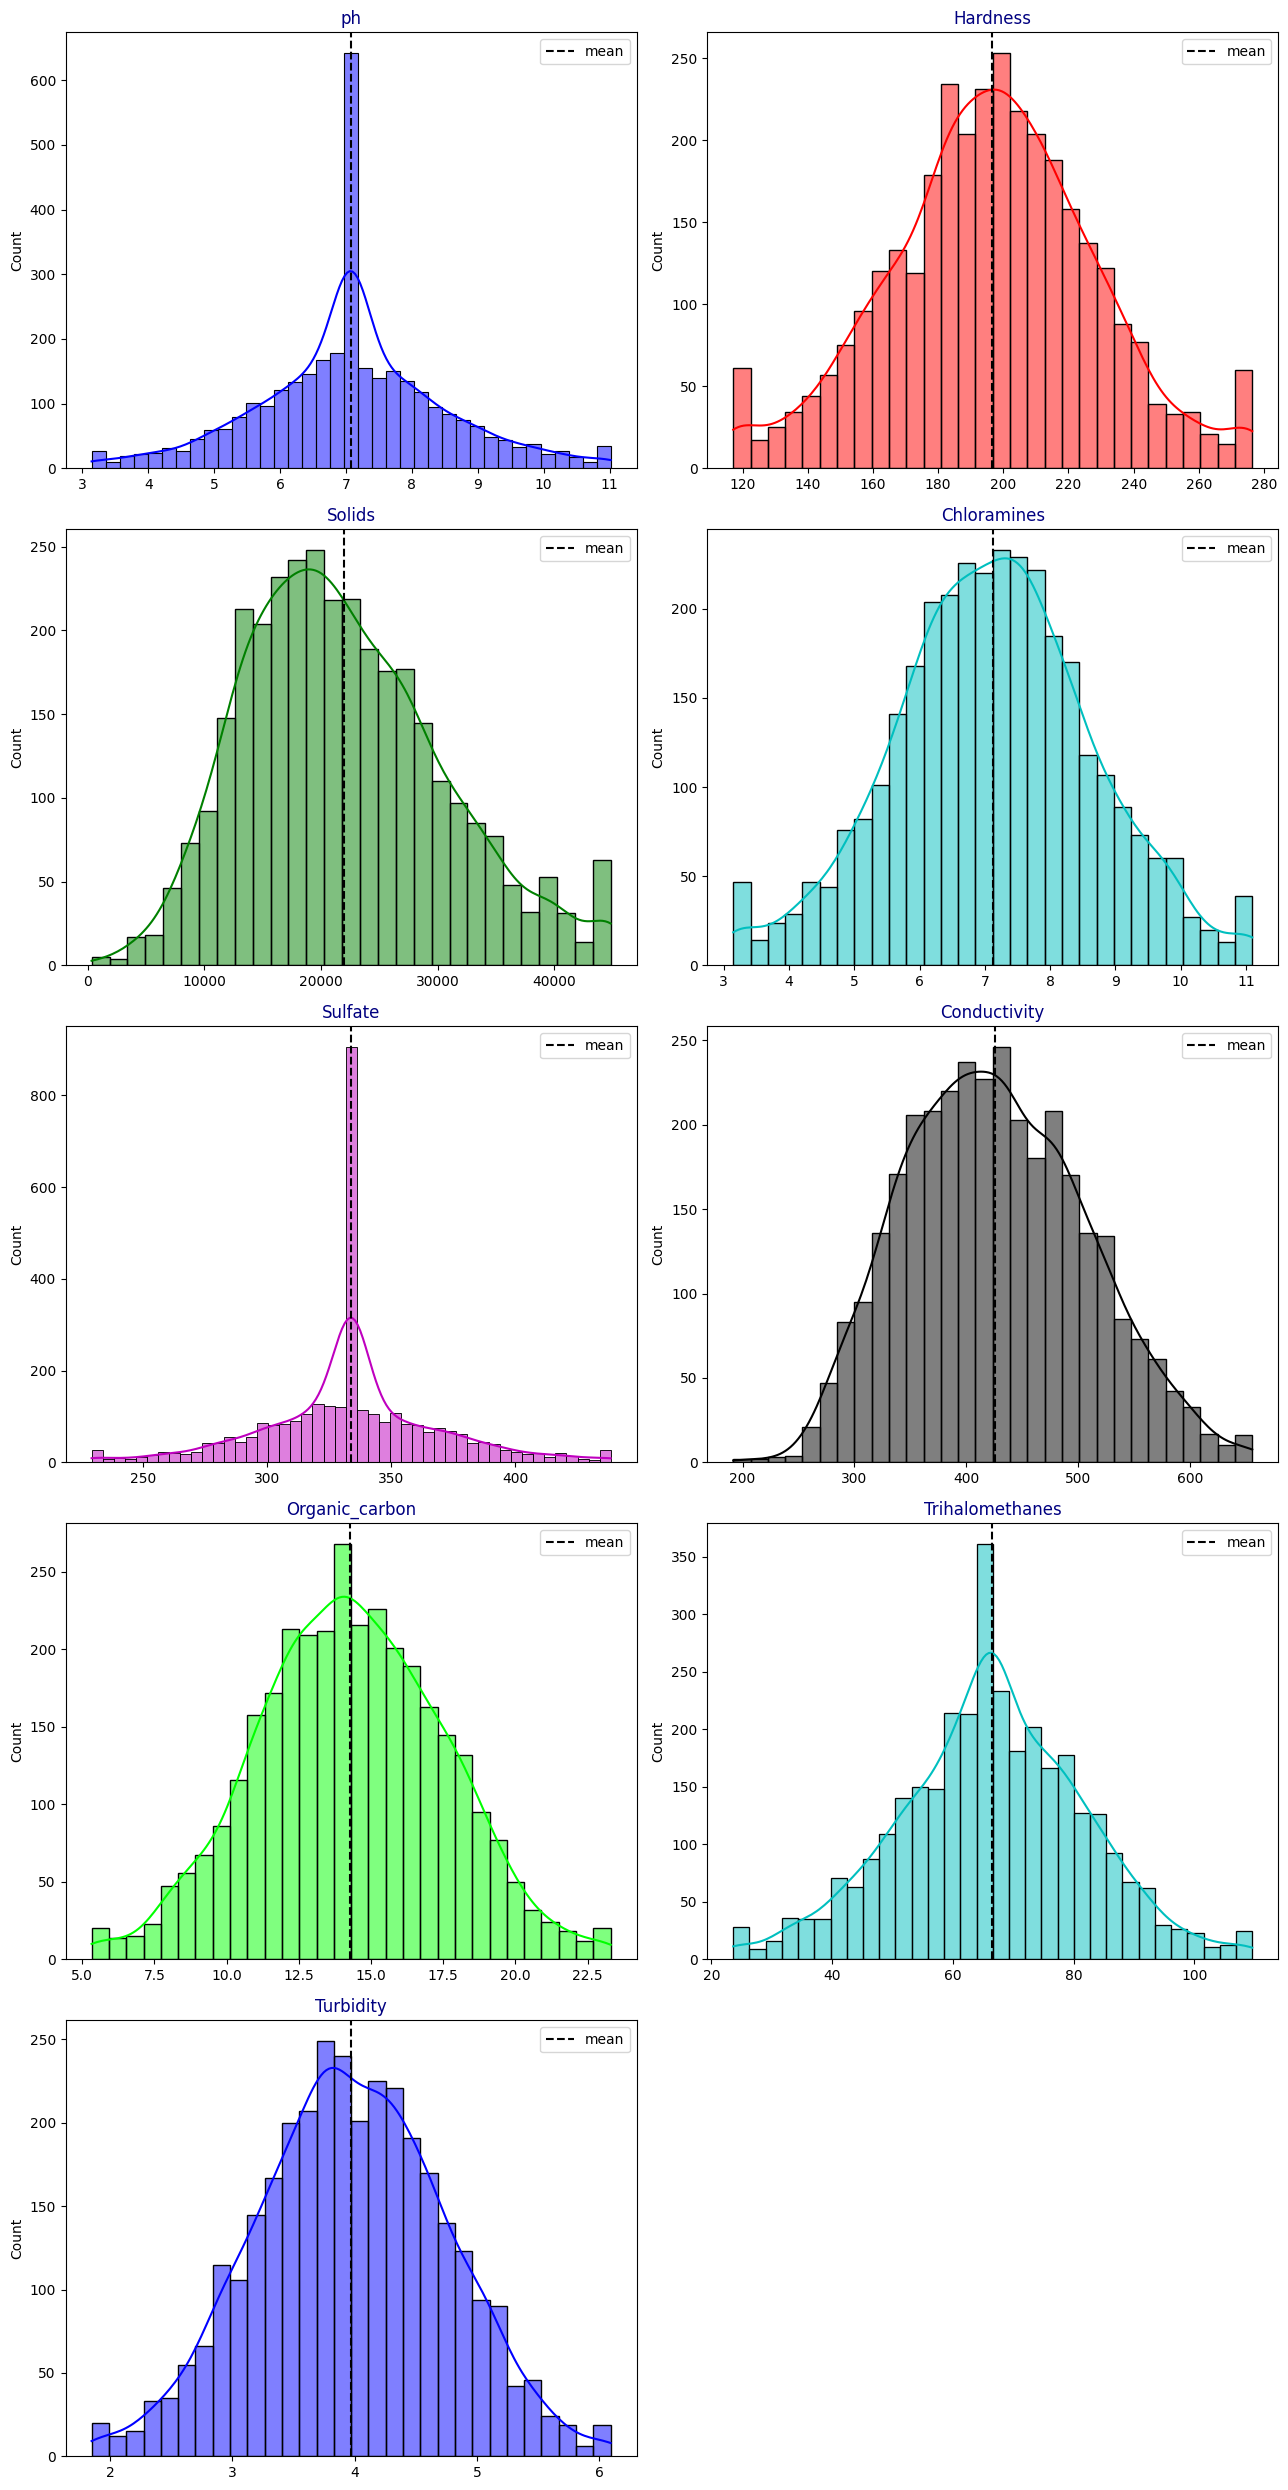

In [24]:
cols = [i for i in water_df.columns if i not in 'Potability']
length = len(cols)
cs = ["b","r","g","c","m","k","lime","c"]
fig = plt.figure(figsize=(13,25))

for j, i in enumerate(cols): # Using enumerate to get both index and column name
    plt.subplot(5,2,j+1)
    ax = sns.histplot(water_df[i],color=cs[j % len(cs)],kde=True) # Cycle through colors using modulo
    ax.set_facecolor("w")
    plt.axvline(water_df[i].mean(),linestyle="dashed",label="mean",color="k")
    plt.legend(loc="best")
    plt.title(i,color="navy")
    plt.xlabel("")

plt.tight_layout()
plt.show()

* ph: Slightly right skewed - No gaussian distribution
* Hardness: Slightly left skewed - No gaussian distribution
* Solids: Right skewed - No gaussian distribution
* Chloramines: Slightly left skewed - 2 gaussians distribution
* Sulfate: Slightly right skewed - No gaussian distribution
* Conductivity: Slightly right skewed - No gaussian distribution
* Organic_carbon: Slightly right skewed - No gaussian distribution
* Trihalomethanes: Slightly right skewed - No gaussian distribution

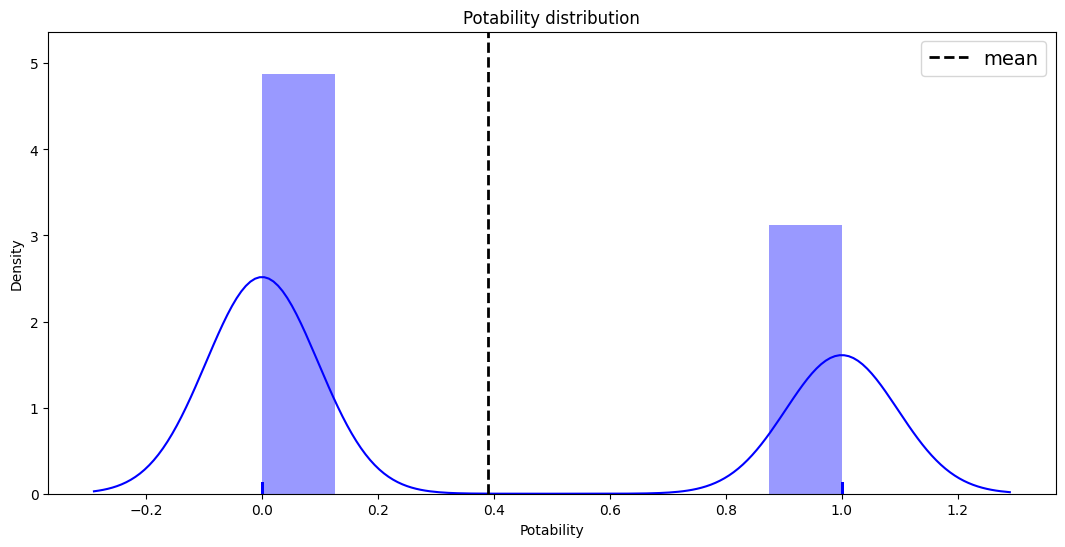

In [25]:
plt.figure(figsize=(13,6))
sns.distplot(water_df["Potability"],color="b",rug=True)
plt.axvline(water_df["Potability"].mean(), linestyle="dashed",color="k", label='mean',linewidth=2)
plt.legend(loc="best",prop={"size":14})
plt.title("Potability distribution")
plt.show()

Potability: Both skewed, with a slight over to right skew distribution, has two gaussians

In [26]:
water_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,3276.0000000,7.0817377,1.4287545,3.1396306,6.2776726,7.0817377,7.8700498,11.0155274
Hardness,3276.0000000,196.3924229,32.0171893,117.1251604,176.8505379,196.9676269,216.6674562,276.3928337
Solids,3276.0000000,21957.1122000,8592.8203969,320.9426113,15666.6902970,20927.8336065,27332.7621274,44831.8698731
Chloramines,3276.0000000,7.1217940,1.5441262,3.1462213,6.1274208,7.1302990,8.1148870,11.0960864
Sulfate,3276.0000000,333.8678617,35.2991302,229.3234890,317.0946377,333.8678617,350.3857563,438.3261792
Conductivity,3276.0000000,426.1299736,80.5641438,191.6475786,365.7344141,421.8849683,481.7923045,655.8791400
Organic_carbon,3276.0000000,14.2834616,3.2883667,5.3280260,12.0658013,14.2183379,16.5576515,23.2954269
Trihalomethanes,3276.0000000,66.4152186,15.5900164,23.6051297,56.6476557,66.4152186,76.6666093,109.5768788
Turbidity,3276.0000000,3.9666121,0.7764086,1.8487975,3.4397109,3.9550276,4.5003198,6.0912332
Potability,3276.0000000,0.3901099,0.4878492,0.0000000,0.0000000,0.0000000,1.0000000,1.0000000


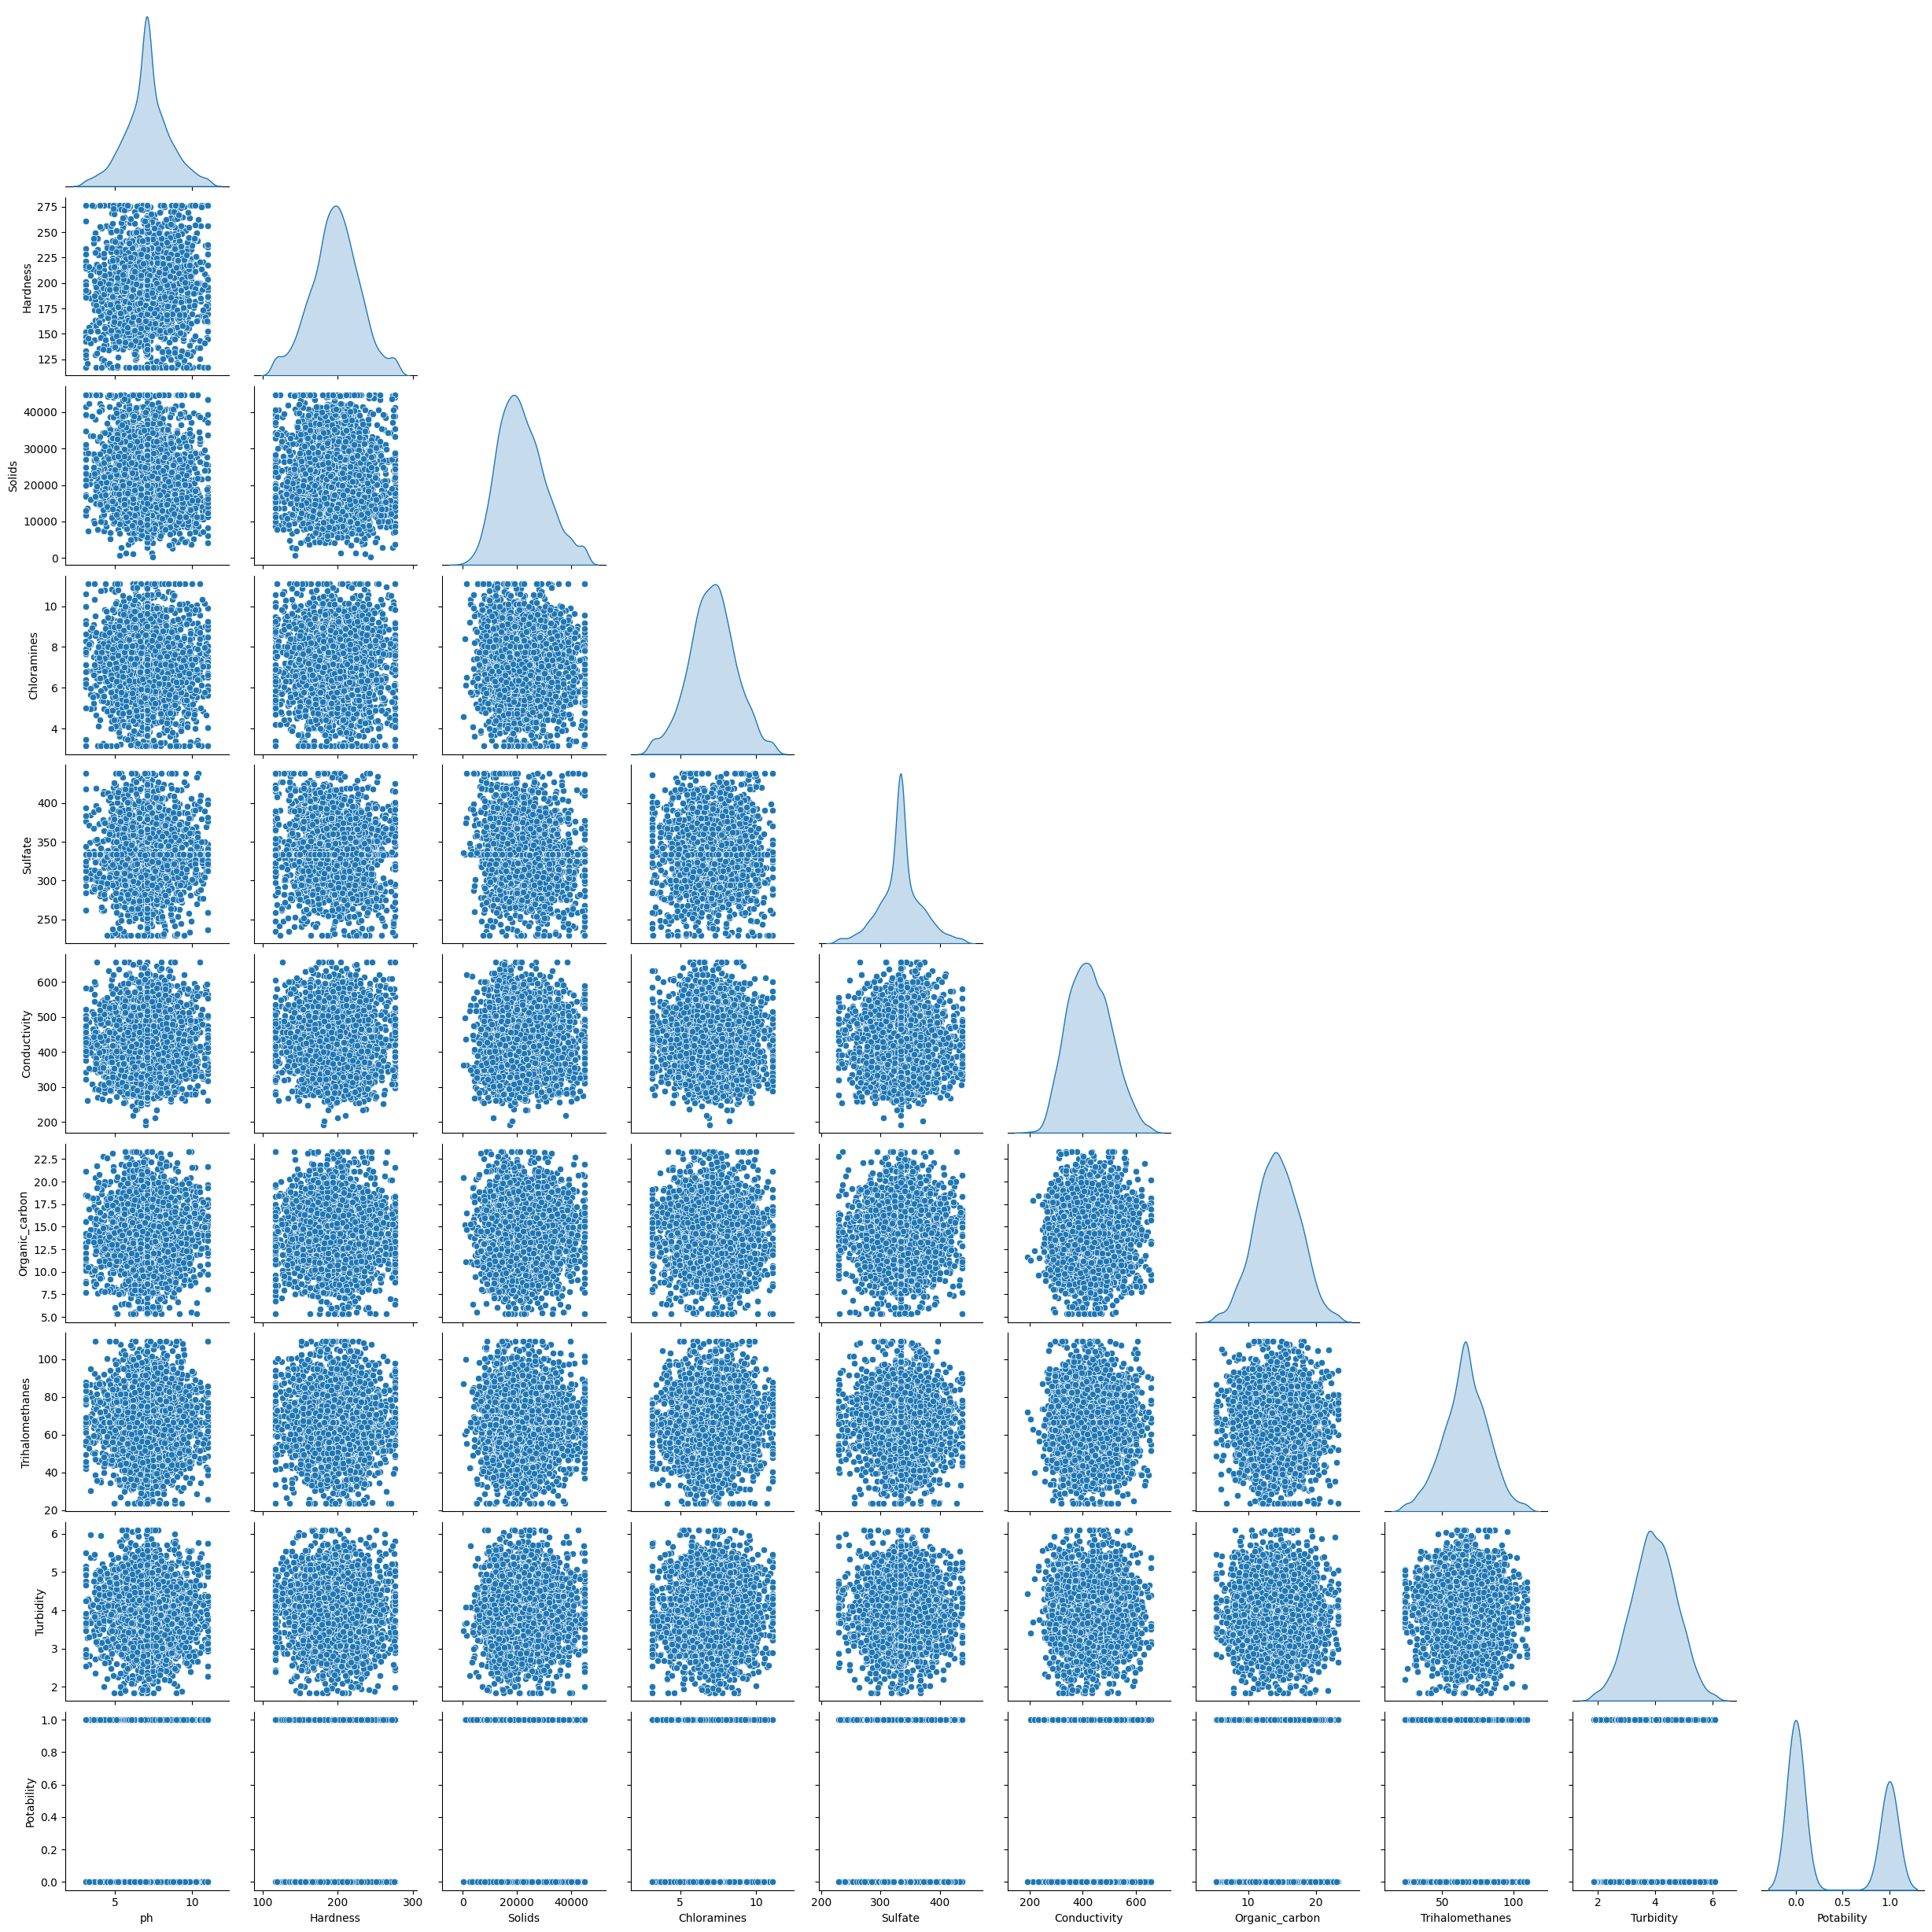

In [27]:
sns.pairplot(water_df, diag_kind="kde", corner=True)
plt.show()

In [28]:
water_df.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.0000000,0.0878806,-0.0792167,-0.0370055,0.0146415,0.0181865,0.0383538,0.0019066,-0.0349144,-0.0022949
Hardness,0.0878806,1.0000000,-0.0485032,-0.0263431,-0.0894096,-0.0250949,0.0024581,-0.0130781,-0.0155881,-0.0133595
Solids,-0.0792167,-0.0485032,1.0000000,-0.0708607,-0.1442476,0.0131768,0.0118165,-0.0115842,0.0209946,0.0318469
Chloramines,-0.0370055,-0.0263431,-0.0708607,1.0000000,0.0295623,-0.0218898,-0.0131844,0.0153199,0.0017293,0.0235233
Sulfate,0.0146415,-0.0894096,-0.1442476,0.0295623,1.0000000,-0.0127289,0.0236753,-0.0252735,-0.0081314,-0.0185999
Conductivity,0.0181865,-0.0250949,0.0131768,-0.0218898,-0.0127289,1.0000000,0.0208589,0.0006373,0.0058564,-0.0078808
Organic_carbon,0.0383538,0.0024581,0.0118165,-0.0131844,0.0236753,0.0208589,1.0000000,-0.0131471,-0.0280893,-0.0292823
Trihalomethanes,0.0019066,-0.0130781,-0.0115842,0.0153199,-0.0252735,0.0006373,-0.0131471,1.0000000,-0.0224511,0.0068516
Turbidity,-0.0349144,-0.0155881,0.0209946,0.0017293,-0.0081314,0.0058564,-0.0280893,-0.0224511,1.0000000,0.0015975
Potability,-0.0022949,-0.0133595,0.0318469,0.0235233,-0.0185999,-0.0078808,-0.0292823,0.0068516,0.0015975,1.0000000


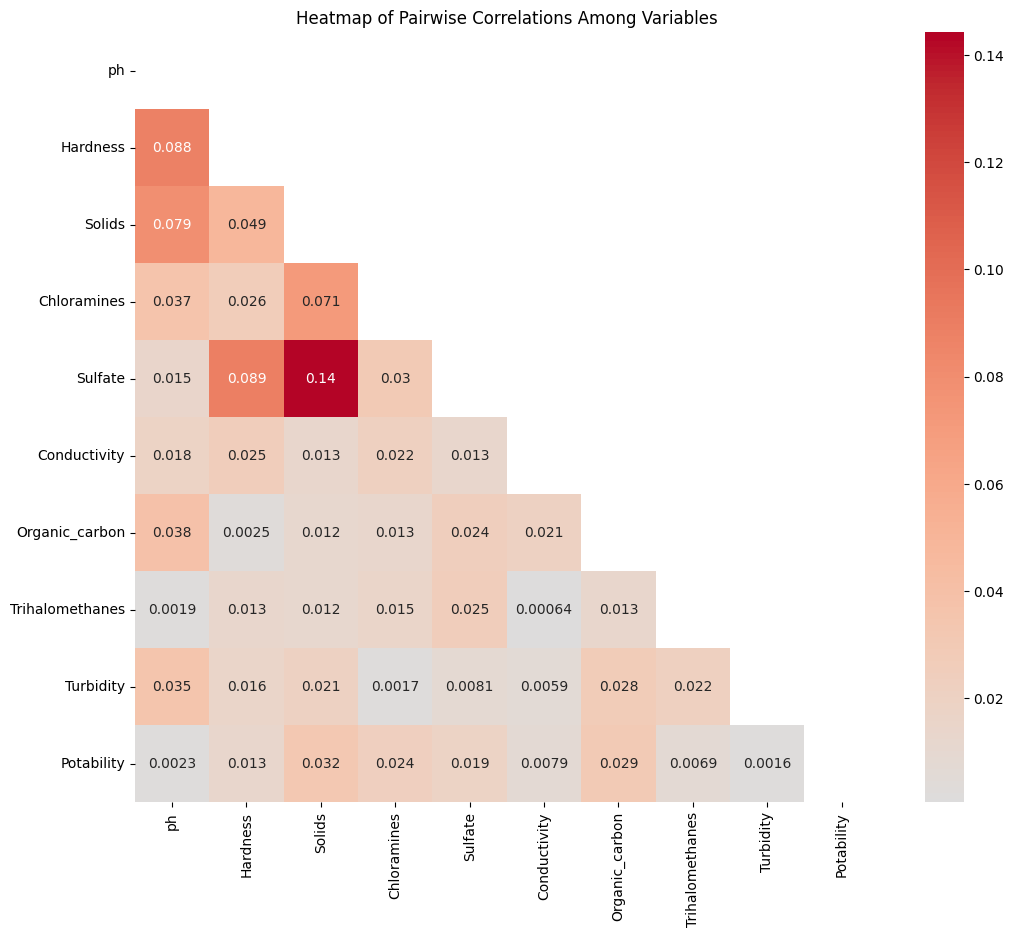

In [29]:
corr = abs(water_df.corr())

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', center=0)
plt.title('Heatmap of Pairwise Correlations Among Variables')

plt.show()

* pH, Solids, Chloramines and Turbidity has enough relationship with the 'Potability' variable
* Organic_carbon and pH has a low positive correlation with each other => New feature: Organic_carbon_oh
* Chloramines and hardness has a low positive correlation with each other => New feature: chloramines_hardness
* Trihalomethanes and solids has a low positive correlation with each other => New feature: trihalomethanes_solids

# **Feature Engineering**

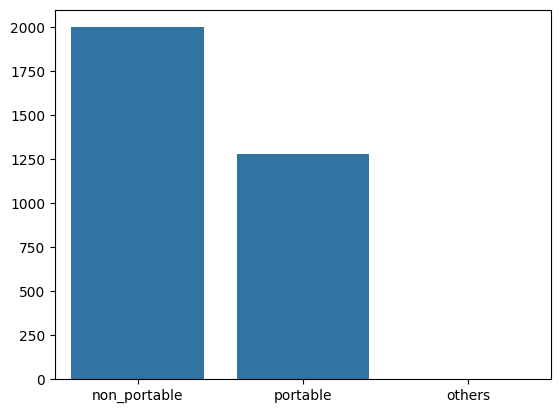

In [30]:
year_categories = {
    "non_portable": 0,
    "portable": 0,
    "others": 0
}

for i in range(len(water_df['Potability'])):
  iter_val = water_df['Potability'][i]
  match iter_val:
    case 0:
      year_categories['non_portable'] += 1
    case 1:
      year_categories['portable'] += 1
    case _:
      year_categories['others'] += 1

sns.barplot(x=list(year_categories.keys()), y=list(year_categories.values()))
plt.show()

**Normalising all features**

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
normalised_df = water_df.copy()
scaler = MinMaxScaler()
normalise_features = [i for i in normalised_df.columns if i != 'Potability']
normalised_df[normalise_features] = scaler.fit_transform(normalised_df[normalise_features])
print("Transformed Data")
normalised_df.head()

Transformed Data


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.5005280,0.5510553,0.4598955,0.5225234,0.6659864,0.8027483,0.2811624,0.7372869,0.2626647,0
1,0.0731916,0.0772144,0.4113398,0.4388785,0.5002059,0.8643053,0.5483257,0.3806360,0.6250793,0
2,0.6297053,0.6725225,0.4400852,0.7710398,0.5002059,0.4888910,0.6423083,0.4980120,0.2845385,0
3,0.6573391,0.6105962,0.4874640,0.6180119,0.6103397,0.3696839,0.7295712,0.8925786,0.6552776,0
4,0.7557987,0.4016907,0.3967126,0.4277278,0.3866565,0.4453881,0.3467532,0.0976235,0.5247641,0


In [33]:
normalised_df.to_csv("normalised_water_potability.csv", index=False)

**Compositing features**

* Organic_carbon and pH has a low positive correlation with each other => New feature: Organic_carbon_ph
* Chloramines and hardness has a low positive correlation with each other => New feature: chloramines_hardness
* Trihalomethanes and solids has a low positive correlation with each other => New feature: trihalomethanes_solids

In [34]:
features_df = normalised_df.copy()

In [35]:
features_df['Organic_carbon_ph'] = np.cov(features_df['Organic_carbon'], features_df['ph'])[0,1]
features_df['chloramines_hardness'] = np.cov(features_df['Chloramines'], features_df['Hardness'])[0,1]
features_df['trihalomethanes_solids'] = np.cov(features_df['Trihalomethanes'], features_df['Solids'])[0,1]

features_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Organic_carbon_ph,chloramines_hardness,trihalomethanes_solids
0,0.5005280,0.5510553,0.4598955,0.5225234,0.6659864,0.8027483,0.2811624,0.7372869,0.2626647,0,0.0012734,-0.0010286,-0.0004055
1,0.0731916,0.0772144,0.4113398,0.4388785,0.5002059,0.8643053,0.5483257,0.3806360,0.6250793,0,0.0012734,-0.0010286,-0.0004055
2,0.6297053,0.6725225,0.4400852,0.7710398,0.5002059,0.4888910,0.6423083,0.4980120,0.2845385,0,0.0012734,-0.0010286,-0.0004055
3,0.6573391,0.6105962,0.4874640,0.6180119,0.6103397,0.3696839,0.7295712,0.8925786,0.6552776,0,0.0012734,-0.0010286,-0.0004055
4,0.7557987,0.4016907,0.3967126,0.4277278,0.3866565,0.4453881,0.3467532,0.0976235,0.5247641,0,0.0012734,-0.0010286,-0.0004055


In [36]:
features_df.to_csv("features_water_potability.csv", index=False)

**Feature selection**

In [37]:
selected_features_df = features_df.copy()

pH, Solids, Chloramines and Turbidity has enough relationship with the 'Potability' variable

In [38]:
features_columns = ['ph', "Solids", "Chloramines", "Turbidity", "Potability", "Organic_carbon_ph", "chloramines_hardness", "trihalomethanes_solids"]
columns_to_drop = [i for i in selected_features_df.columns if i not in features_columns]
selected_features_df.drop(columns=columns_to_drop, inplace=True)
selected_features_df.head()

,ph,Solids,Chloramines,Turbidity,Potability,Organic_carbon_ph,chloramines_hardness,trihalomethanes_solids
0,0.5005280,0.4598955,0.5225234,0.2626647,0,0.0012734,-0.0010286,-0.0004055
1,0.0731916,0.4113398,0.4388785,0.6250793,0,0.0012734,-0.0010286,-0.0004055
2,0.6297053,0.4400852,0.7710398,0.2845385,0,0.0012734,-0.0010286,-0.0004055
3,0.6573391,0.4874640,0.6180119,0.6552776,0,0.0012734,-0.0010286,-0.0004055
4,0.7557987,0.3967126,0.4277278,0.5247641,0,0.0012734,-0.0010286,-0.0004055


In [39]:
selected_features_df.to_csv("selected_features_normalised_water_potability.csv", index=False)

In [40]:
features_columns = ['ph', "Solids", "Chloramines", "Turbidity", "Potability"]
columns_to_drop = [i for i in water_df.columns if i not in features_columns]
water_df.drop(columns=columns_to_drop, inplace=True)
water_df.head()

,ph,Solids,Chloramines,Turbidity,Potability
0,7.0817377,20791.3189807,7.3002119,2.9631354,0
1,3.7160801,18630.0578580,6.6352459,4.5006563,0
2,8.0991242,19909.5417323,9.2758836,3.0559337,0
3,8.3167659,22018.4174408,8.0593324,4.6287705,0
4,9.0922235,17978.9863389,6.5466000,4.0750754,0


In [41]:
water_df.to_csv("selected_features_water_potability.csv", index=False)

# **Model development**

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Dict

Define test result

In [43]:
test_result: Dict[str, int] = {}

Define shared function for import csv, split data, fit and predict

In [44]:
@dataclass
class ModelConfig:
  path_to_dataset: str
  feature_cols: List[str]
  target_col: str
  is_df_scaled: Optional[bool] = False
  test_size: Optional[float] = 0.3
  random_state: Optional[int] = 1
  ref_to_test_result: Optional[Dict[str, int]] = field(default_factory=lambda: test_result)

In [45]:
def create_model(cfg: ModelConfig) -> DecisionTreeClassifier:
  _internal_df = pd.read_csv(cfg.path_to_dataset)
  _internal_x = _internal_df[cfg.feature_cols]
  _internal_y = _internal_df[cfg.target_col]
  _internal_x_train, _internal_x_test, _internal_y_train, _internal_y_test = train_test_split(_internal_x, _internal_y, test_size=cfg.test_size, random_state=cfg.random_state)

  _internal_clf = DecisionTreeClassifier()
  _internal_clf = _internal_clf.fit(_internal_x_train, _internal_y_train)
  _internal_y_pred = _internal_clf.predict(_internal_x_test)
  print("Accuracy:", metrics.accuracy_score(_internal_y_test, _internal_y_pred))
  if cfg.ref_to_test_result is not None:
    _internal_name_of_file = cfg.path_to_dataset.split("/")[-1].split(".")[0]
    cfg.ref_to_test_result[_internal_name_of_file] = metrics.accuracy_score(_internal_y_test, _internal_y_pred)
  return _internal_clf

In [46]:
features_without_normalisation_options = ModelConfig("cleaned_data_water_potability.csv", ["ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"], "Potability")
create_model(features_without_normalisation_options)

Accuracy: 0.5513733468972533


DecisionTreeClassifier()

In [47]:
features_with_normalisation_options = ModelConfig("normalised_water_potability.csv", ["ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"], "Potability")
create_model(features_with_normalisation_options)

Accuracy: 0.5544252288911495


DecisionTreeClassifier()

In [48]:
features_with_normalisation_and_composite_options = ModelConfig("features_water_potability.csv", ["ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity", "Organic_carbon_ph", "chloramines_hardness", "trihalomethanes_solids"], "Potability")
create_model(features_with_normalisation_and_composite_options)

Accuracy: 0.5625635808748728


DecisionTreeClassifier()

In [49]:
selected_features_normalised_composite_options = ModelConfig("selected_features_normalised_water_potability.csv", ["ph", "Solids", "Chloramines", "Turbidity", "Organic_carbon_ph", "chloramines_hardness", "trihalomethanes_solids"], "Potability")
create_model(selected_features_normalised_composite_options)

Accuracy: 0.5310274669379451


DecisionTreeClassifier()

In [50]:
selected_features_non_normalised_non_composite_options = ModelConfig("selected_features_water_potability.csv", ["ph", "Solids", "Chloramines", "Turbidity"], "Potability")
create_model(selected_features_non_normalised_non_composite_options)

Accuracy: 0.5350966429298067


DecisionTreeClassifier()

In [51]:
for k, v in enumerate(test_result):
  print(f"{k+1}. {v}: {test_result[v] * 100}")

1. cleaned_data_water_potability: 55.13733468972533
2. normalised_water_potability: 55.442522889114954
3. features_water_potability: 56.25635808748728
4. selected_features_normalised_water_potability: 53.102746693794515
5. selected_features_water_potability: 53.50966429298067


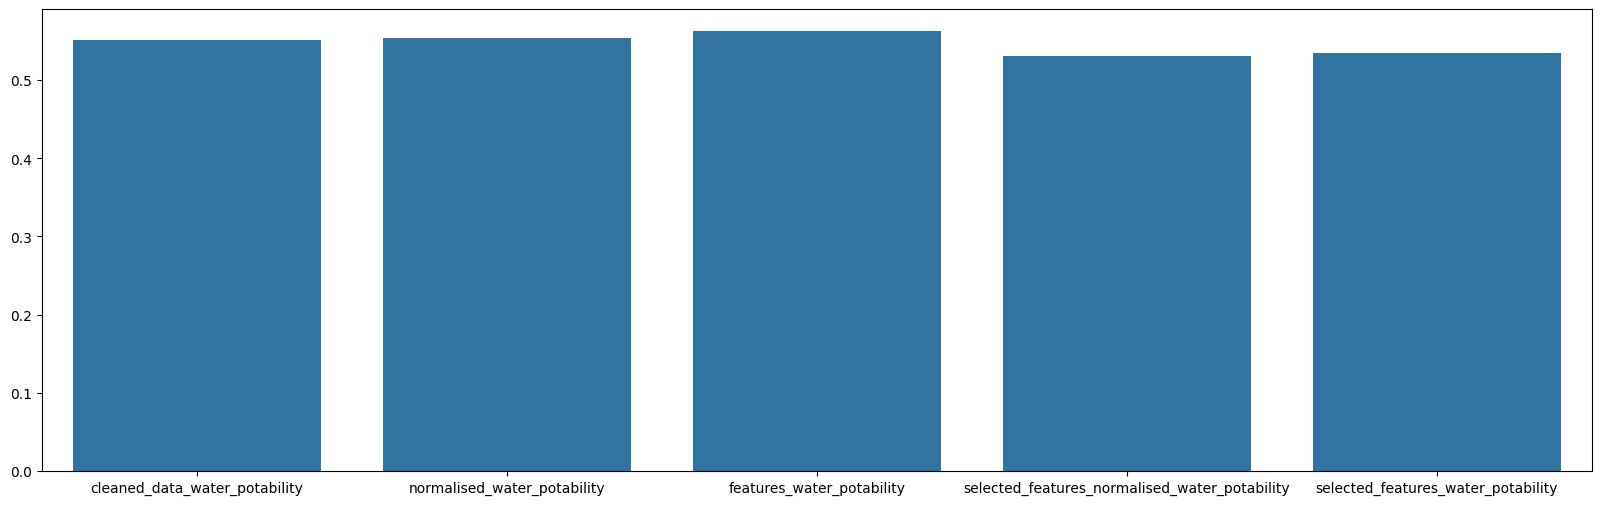

In [52]:
plt.figure(figsize=(20, 6))
sns.barplot(x=list(test_result.keys()), y=list(test_result.values()))
plt.show()